In [303]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from torch import nn
from torch.distributions import Normal
import abc

In [304]:
class ActionSelector(nn.Module, abc.ABC):
    def __init__(self, k):
        """
        :param k: Number of candidates that will be created
        """
        super().__init__()
        self.k = k

    @abc.abstractmethod
    def forward(self, **kwargs) -> tuple[torch.Tensor, torch.Tensor]:
        """
        returns
            - actions: Shape [k x N]
                0 = NOOP
                1 = Clone
                2 = Split
                3 = Prune (does not work in old implementation)
            - log_probabilities for each candidate: Shape [k]
        """
        pass


class ParamNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=3, increase_bias=2.0, decrease_bias=-2.0):
        super(ParamNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.init_weights(increase_bias, decrease_bias)

    def init_weights(self, increase_bias=2.0, decrease_bias=-2.0):
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc3.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        #nn.init.zeros_(self.fc3.bias)
        
        # Initialize fc3 weights and biases for changed probabilities
        nn.init.zeros_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)  # Initialize biases to 0
        
        # Example: Increase the bias for a specific action to increase its initial probability
        # Assuming you want to favor the first action initially:
        self.fc3.bias.data[0] = increase_bias  # Increase bias for the first action
        self.fc3.bias.data[1] = decrease_bias  # Decrease bias for the second action
        self.fc3.bias.data[2] = decrease_bias  # Decrease bias for the third action
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ParamBasedActionSelector(ActionSelector):
    def __init__(self, input_size=3, k=2, hidden_size=16, increase_bias=2.0, decrease_bias=-2.0):
        super().__init__(k=k)
        self.param_network = ParamNetwork(input_size, hidden_size, increase_bias=increase_bias, decrease_bias=decrease_bias)

    def forward(self, inputs):
        # Get action probabilities from the parameter network
        logits = self.param_network(inputs)
        action_probs = torch.softmax(logits, dim=-1)
        # Print logits and action probabilities for debugging
        #print("Logits: ", logits)
        #print("Action probabilities: ", action_probs)
        
        # Probabilistically sample k action candidates using rsample
        action_dist = torch.distributions.Categorical(action_probs)
        actions = action_dist.sample((self.k,)).to("cpu")   # using sample for discrete actions
        log_probs = action_dist.log_prob(actions)

        return actions, log_probs.squeeze(), action_probs

In [305]:
import math
math.log(100000)

11.512925464970229

In [306]:
# Load the saved model
action_selector = ParamBasedActionSelector(k=1, hidden_size=16, increase_bias=-2.0, decrease_bias=2.0).to("cpu")

#model_path = "../gaussian_splatting_rl/hydra/multirun/2024-09-05/22-42-59/4/meta_model.torch"
model_path = "/bigwork/nhmlhuer/git/gaussian_splatting_rl/hydra/multirun/2024-09-11/21-37-47/7/meta_model.torch"

action_selector.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [307]:
# Create random inputs
num_samples = 2000
#grad_norms = torch.rand(num_samples) * (1e-2 - 1e-8) + 1e-8  # Random gradient norms between 1e-8 and 1e-3 used for runs in 22-42-59
grad_norms = torch.rand(num_samples) * 10 -5
max_scalings = torch.rand(num_samples) * 6 - 3  # Random max scalings between -3 and 3
opacities = torch.rand(num_samples) * 6 - 3  # Random opacities between -3 and 3

# Stack inputs together for the ParamBasedActionSelector
inputs = torch.stack([grad_norms, max_scalings, opacities], dim=-1)

In [308]:
# Use the action selector to get actions
actions, _, action_probs = action_selector.forward(inputs)

# Move inputs and actions to CPU for plotting
inputs_np = inputs.cpu().numpy()
actions_np = actions.cpu().numpy()
action_probs_np = action_probs.detach().cpu().numpy()  # Detach action_probs before converting to NumPy
unique_values = np.unique(actions_np)
unique_counts = np.bincount(actions_np.flatten())

for value, count in zip(unique_values, unique_counts):
    print(f"Action {value}: {count} occurrences")

Action 0: 1692 occurrences
Action 1: 308 occurrences


In [309]:
actions_np = actions_np.astype(int).flatten()
actions_np

array([0, 0, 1, ..., 1, 0, 1])

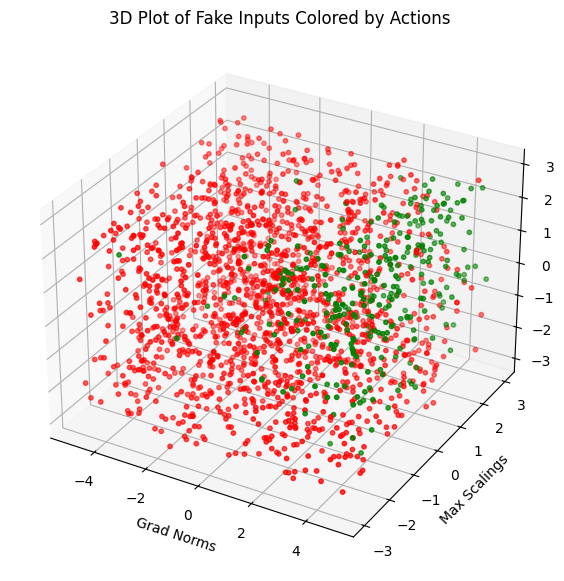

In [310]:
if len(inputs_np) <= 100000:
    # Create a 3D scatter plot of the inputs, colored by action
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Define colors for each action
    colors = ['red', 'green', 'blue']
    # RED = Noop, GREEN = Clone, BLUE = Split
    action_colors = np.array([colors[a] for a in actions_np])

    # Plot the inputs in 3D, colored by action
    sc = ax.scatter(inputs_np[:, 0], inputs_np[:, 1], inputs_np[:, 2], c=action_colors, s=10)

    # Set axis labels
    ax.set_xlabel('Grad Norms')
    ax.set_ylabel('Max Scalings')
    ax.set_zlabel('Opacities')
    ax.set_title('3D Plot of Fake Inputs Colored by Actions')

    # Show the plot
    plt.show()

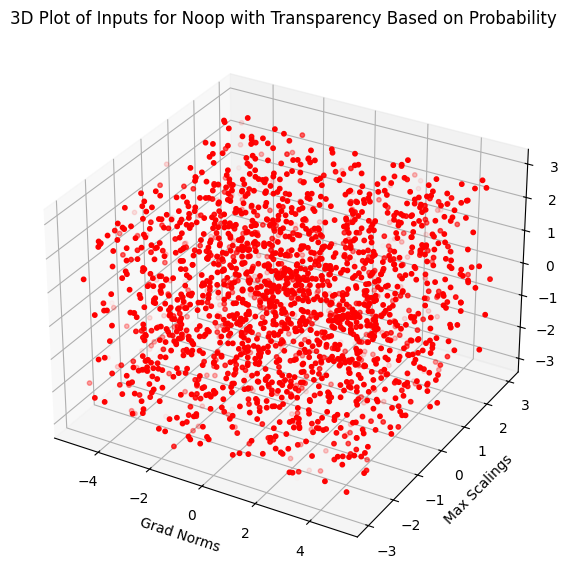

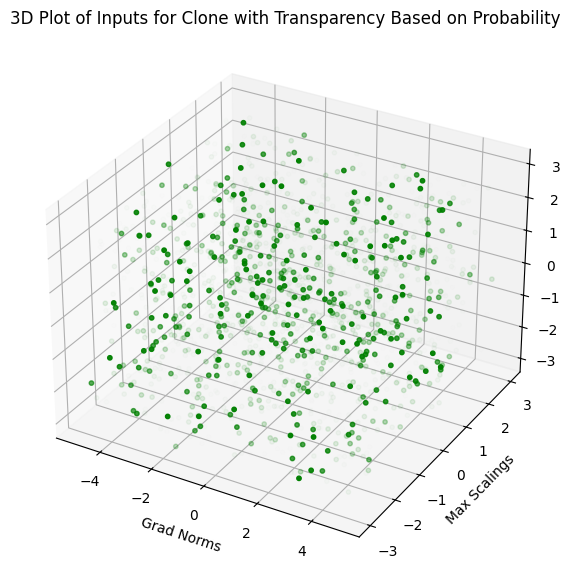

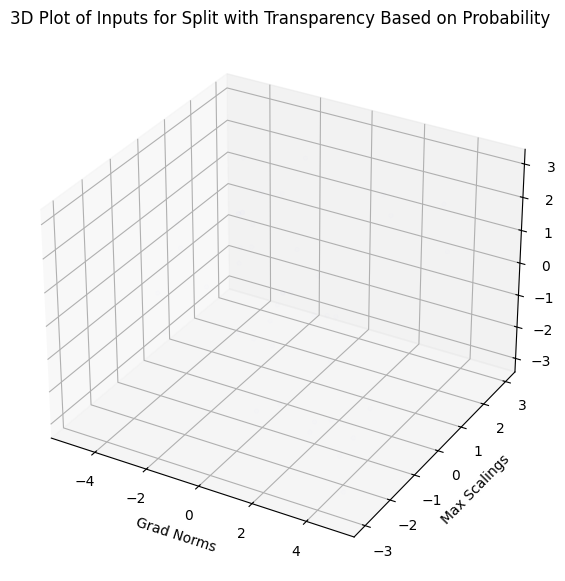

In [311]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming inputs_np is a numpy array of shape [N, 3] containing the input features
# And action_probs is a numpy array of shape [N, 3] containing the probabilities for each action

# Define action names and corresponding colors
actions = ['Noop', 'Clone', 'Split']
colors = ['red', 'green', 'blue']  # Noop = red, Clone = green, Split = blue

# Now you can proceed to plot each action's 3D scatter plot with transparency based on probabilities
for i, action_name in enumerate(actions):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Set the alpha (transparency) based on the action probability for the current action
    alpha_values = action_probs_np[:, i]  # Use detached action probabilities

    # Plot the inputs with transparency based on the action probability
    sc = ax.scatter(inputs_np[:, 0], inputs_np[:, 1], inputs_np[:, 2], c=colors[i], alpha=alpha_values, s=10)

    # Set axis labels and title
    ax.set_xlabel('Grad Norms')
    ax.set_ylabel('Max Scalings')
    ax.set_zlabel('Opacities')
    ax.set_title(f'3D Plot of Inputs for {action_name} with Transparency Based on Probability')

    # Show the plot
    plt.show()

In [314]:
import plotly.graph_objects as go
# Create the 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=inputs_np[:, 0],
    y=inputs_np[:, 1],
    z=inputs_np[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=action_colors,  # Color points by action
        opacity=0.8
    )
)])

# Set plot title and axis labels
fig.update_layout(
    title="Interactive 3D Plot of Fake Inputs Colored by Actions",
    scene=dict(
        xaxis_title="Grad Norms",
        yaxis_title="Max Scalings",
        zaxis_title="Opacities"
    )
)

# Show the plot